#***Neironka***

In [1]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://azwnnln0cat-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [2]:
!pip install flask-ngrok

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install face_recognition

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import face_recognition
import pickle
import os
import cv2


KNOWN_FACES_DIR = '/content/drive/MyDrive/Server/static/dataset/train'
UNKNOWN_FACES_DIR = '/content/drive/MyDrive/Server/static/dataset/test'
TOLERANCE = 0.5
FRAME_THICKNESS = 3
FONT_THICKNESS = 2
MODEL = 'cnn'

known_faces = []
known_names = []
def add_face(image_path, id):
    image = face_recognition.load_image_file(image_path)
    
    encoding = face_recognition.face_encodings(image)
    if len(encoding) > 0:
        encoding = encoding[0]
    else:
        return
    known_faces.append(encoding)
    known_names.append(id)

def find_face(image_path):
    image = face_recognition.load_image_file(image_path)

    locations = face_recognition.face_locations(image, model=MODEL)
    encodings = face_recognition.face_encodings(image, locations)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    match = False
    print(f'found {len(encodings)} face(s)')
    for face_encoding, face_location in zip(encodings, locations):

        results = face_recognition.compare_faces(known_faces, face_encoding, TOLERANCE)

        if True in results:

            match = known_names[results.index(True)]

            top_left = (face_location[3], face_location[0])
            bottom_right = (face_location[1], face_location[2])

            cv2.rectangle(image, top_left, bottom_right, 255, FRAME_THICKNESS)

            top_left = (face_location[3], face_location[2])
            bottom_right = (face_location[1], face_location[2] + 22)

            cv2.rectangle(image, top_left, bottom_right, 255, cv2.FILLED)

            #cv2.putText(image, match, (face_location[3] + 10, face_location[2] + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), FONT_THICKNESS)
    imgplot = plt.imshow(image)
    plt.show()
    cv2.imwrite("/content/drive/MyDrive/Server/static/dataset/answer/ans.jpg", image)
    return match

def load_data():
    file1 = open("/content/drive/MyDrive/Server/static/dataset/pretrained/known_faces.pkl", "rb")
    file2 = open("/content/drive/MyDrive/Server/static/dataset/pretrained/known_names.pkl", "rb")
    known_faces = pickle.load(file1)
    known_names = pickle.load(file2)
    file1.close()
    file2.close()
    
def add_data(path):
    temp = path.split("/")[-1]
    id = '_'.join(temp.split("_")[:-1])
    print(id)
    add_face(path, id)

def train_data():
    for name in os.listdir(KNOWN_FACES_DIR):
        id = '_'.join(name.split("_")[:-1])
        print(id)
        
        add_face(f'{KNOWN_FACES_DIR}/{name}', id)

        file1 = open("/content/drive/MyDrive/Server/static/dataset/pretrained/known_faces.pkl", "wb")
        file2 = open("/content/drive/MyDrive/Server/static/dataset/pretrained/known_names.pkl", "wb")
        pickle.dump(known_faces, file1)
        pickle.dump(known_names, file2)
        file1.close()
        file2.close()

#***Parser classes***

In [6]:
from abc import ABC, abstractmethod


class Provider(ABC):
    @staticmethod
    @abstractmethod
    def provide_data(**kwargs):
        pass

    @staticmethod
    @abstractmethod
    def use(**kwargs):
        pass

In [7]:
import json
import os

class TerroristProvider(Provider):
    @staticmethod
    def provide_data(first_name: str, last_name: str, birthdate: str):
        first_name = first_name.upper()
        last_name = last_name.upper()
        with open('/content/drive/MyDrive/Server/static/dataset/json/terrorist.json') as file:
            data = json.load(file)
            for pdata in data:
                if pdata['firstname'] == first_name and pdata['lastname'] == last_name \
                        and pdata['birthdate'] == birthdate:
                    return True
            return False

    @staticmethod
    def use(**kwargs) -> str:
        first_name = kwargs.get('firstname')
        last_name = kwargs.get('lastname')
        birthdate = kwargs.get('birthdate')
        if TerroristProvider.provide_data(first_name, last_name, birthdate):
            return 'Есть в списке террористов и экстремистов (комплайнс проверка по 115-ФЗ)'

In [8]:
import time

import requests
import json
import os

class FsspProvider(Provider):
    @staticmethod
    def provide_data(first_name: str, last_name: str, region: int, birthdate: str):
        first_name = first_name.upper()
        last_name = last_name.upper()
        req = f'?token={os.environ["fssp_token"]}&' \
              f'region={region}&' \
              f'firstname={first_name}&' \
              f'lastname={last_name}&' \
              f'birthdate={birthdate}'
        response = requests.get(f'http://api-ip.fssprus.ru/api/v1.0/search/physical{req}')
        if response.status_code != 200:
            return []
        resp_data: dict = json.loads(response.content)
        task = resp_data['response']['task']
        req = f'?token={"W9kswdsrfD2J"}&' \
              f'task={task}'
        response = requests.get(f'http://api-ip.fssprus.ru/api/v1.0/result{req}')
        if response.status_code != 200:
            return []
        resp_data = json.loads(response.content)
        debts = resp_data['response']['result']
        res = []
        for d in debts:
            if d["result"]:
                res.append(d["result"]['subject'])
        return res

    @staticmethod
    def use(**kwargs) -> str:
        first_name = kwargs.get('firstname')
        last_name = kwargs.get('lastname')
        city = kwargs.get('city')
        birthdate = kwargs.get('birthdate')
        try:
            with open('/content/drive/MyDrive/Server/static/dataset/json/city_number.json', 'r') as f:
                cr = json.load(f)
                region = int(cr[city])
        except KeyError:
            region = 50
        cnt = 0
        res = []
        while not res and cnt < 10:
            res = FsspProvider.provide_data(first_name, last_name, region, birthdate)
            cnt += 1
            time.sleep(0.5)
        if len(res):
            return json.dumps(res)

In [9]:
!pip install vk

In [10]:
import vk
from collections import Counter


class VkParser:

    def __init__(self, vk_token):
        self.session = vk.Session(access_token=vk_token)
        self.vk_api = vk.API(self.session, v=5.89)
        self.rel_dict = {1: "не женат/не замужем",
                         3: "помолвлен/помолвлена",
                         4: "женат/замужем",
                         8: "в гражданском браке",
                         2: "есть друг/есть подруга"}
        self.pers = {}

    def find_main_info(self, user_id):
        person = self.vk_api.users.get(user_ids=user_id, lang="ru", fields='city, country, contacts, connections,'
                                                                           'universities, career,'
                                                                           'relation, photo_200_orig, sex, bdate, counters')

        if 'deactivated' in person[0]:
            if person[0]['deactivated'] == 'deleted' or person[0]['deactivated'] == 'banned':
                return 'Пользователь удален или забанен'

        private = person[0]['is_closed']

        # f = open('person.txt', 'w')
        # f.write(str(person))
        firstname = person[0]['first_name']
        lastname = person[0]['last_name']
        country = 'не указано'
        city = 'не указано'
        jobs = []
        university = []
        relation = 0
        contacts = []
        military = 'не указано'
        mob_phone = 'не указано'
        home_phone = 'не указано'
        bdate = 'не указано'
        sex = 'не указано'
        photo_url = [person[0]['photo_200_orig']]

        if 'country' in person[0]:
            country = person[0]['country']['title']

        if 'city' in person[0]:
            city = person[0]['city']['title']

        if 'career' in person[0]:
            jobs = person[0]['career']

        if 'universities' in person[0]:
            university = person[0]['universities']

        if 'relation' in person[0]:
            relation = person[0]['relation']

        if relation in self.rel_dict.keys():
            relation = self.rel_dict[relation]
            if 'relation_partner' in person[0]:
                part_name = person[0]['relation_partner']['first_name'] + ' ' + person[0]['relation_partner'][
                    'last_name']
                partner = {
                    'relation': relation,
                    'name': part_name
                }
            else:
                partner = {
                    'relation': relation,
                    'name': 'не указано'
                }
        else:
            relation = 'не указано'
            partner = {
                'relation': relation
            }

        if 'bdate' in person[0]:
            bdate = person[0]['bdate']

        sex_id = person[0]['sex']
        if sex_id == 2:
            sex = 'мужской'
        elif sex_id == 1:
            sex = 'женский'

        if 'mobile_phone' in person[0]:
            mob_phone = person[0]['mobile_phone']

        if 'home_phone' in person[0]:
            home_phone = person[0]['home_phone']

        contacts.append({'home_phone': home_phone})
        contacts.append({'mob_phone': mob_phone})

        if 'military' in person[0]:
            military = person[0]['military']

        if 'facebook' in person[0]:
            contacts.append({'facebook': person[0]['facebook']})

        if 'instagram' in person[0]:
            contacts.append({'instagram': person[0]['instagram']})

        if 'skype' in person[0]:
            contacts.append({'skype': person[0]['skype']})

        if 'twitter' in person[0]:
            contacts.append({'twitter': person[0]['twitter']})

        # change id to city title
        # country not working because of authorization error
        for job in jobs:
            job['city_id'] = self.vk_api.database.getCitiesById(city_ids=job['city_id'], lang='ru')[0]['title']

        interests = []

        if not private:
            # find interests of user
            groups = self.vk_api.users.getSubscriptions(user_id=person[0]['id'], extended=True,
                                                        fields='activity, description', lang='ru')

            if groups['count'] > 0:

                groups = groups['items']
                for g in groups:
                    interests.append(g['activity'])
                interests = dict(Counter(interests))

                for i in interests.keys():
                    interests[i] = interests[i] / len(groups) * 100

        filtered_person = {

            'firstname': firstname,
            'lastname': lastname,
            'country': country,
            'birthdate': bdate,
            'sex': sex,
            'city': city,
            'job': jobs,
            'education': university,
            'contacts': contacts,
            'military': military,
            'photo': photo_url,
            'relation': partner,
            'interests': interests
        }
        self.pers = filtered_person
        return filtered_person

    # add photos from profile
    def get_profile_photos(self, vk_token_outh, user_id):
        session = vk.Session(access_token=vk_token_outh)
        vk_api = vk.API(session, v=5.89)
        person = vk_api.users.get(user_ids=user_id)
        print(person)
        if 'deactivated' in person[0]:
            return 'deactivated'

        if person[0]['is_closed']:
            return 'private'

        self.pers['photo'] = []
        photos = vk_api.photos.getProfile(owner_id=person[0]['id'])
        for photo in photos['items']:
            self.pers['photo'].append(photo['sizes'][len(photo['sizes']) - 1]['url'])
        return self.pers['photo']

#***Parser VK***


In [11]:
import vk
from collections import Counter


class VkParser:

    def __init__(self, vk_token):
        self.session = vk.Session(access_token=vk_token)
        self.vk_api = vk.API(self.session, v=5.89)
        self.rel_dict = {1: "не женат/не замужем",
                         3: "помолвлен/помолвлена",
                         4: "женат/замужем",
                         8: "в гражданском браке",
                         2: "есть друг/есть подруга"}
        self.pers = {}

    def find_main_info(self, user_id):
        person = self.vk_api.users.get(user_ids=user_id, lang="ru", fields='city, country, contacts, connections,'
                                                                           'universities, career,'
                                                                           'relation, photo_200_orig, sex, bdate, counters')

        if 'deactivated' in person[0]:
            if person[0]['deactivated'] == 'deleted' or person[0]['deactivated'] == 'banned':
                return 'Пользователь удален или забанен'

        private = person[0]['is_closed']

        # f = open('person.txt', 'w')
        # f.write(str(person))
        firstname = person[0]['first_name']
        lastname = person[0]['last_name']
        country = 'не указано'
        city = 'не указано'
        jobs = []
        university = []
        relation = 0
        contacts = []
        military = 'не указано'
        mob_phone = 'не указано'
        home_phone = 'не указано'
        bdate = 'не указано'
        sex = 'не указано'
        photo_url = [person[0]['photo_200_orig']]

        if 'country' in person[0]:
            country = person[0]['country']['title']

        if 'city' in person[0]:
            city = person[0]['city']['title']

        if 'career' in person[0]:
            jobs = person[0]['career']

        if 'universities' in person[0]:
            university = person[0]['universities']

        if 'relation' in person[0]:
            relation = person[0]['relation']

        if relation in self.rel_dict.keys():
            relation = self.rel_dict[relation]
            if 'relation_partner' in person[0]:
                part_name = person[0]['relation_partner']['first_name'] + ' ' + person[0]['relation_partner'][
                    'last_name']
                partner = {
                    'relation': relation,
                    'name': part_name
                }
            else:
                partner = {
                    'relation': relation,
                    'name': 'не указано'
                }
        else:
            relation = 'не указано'
            partner = {
                'relation': relation
            }

        if 'bdate' in person[0]:
            bdate = person[0]['bdate']

        sex_id = person[0]['sex']
        if sex_id == 2:
            sex = 'мужской'
        elif sex_id == 1:
            sex = 'женский'

        if 'mobile_phone' in person[0]:
            mob_phone = person[0]['mobile_phone']

        if 'home_phone' in person[0]:
            home_phone = person[0]['home_phone']

        contacts.append({'home_phone': home_phone})
        contacts.append({'mob_phone': mob_phone})

        if 'military' in person[0]:
            military = person[0]['military']

        if 'facebook' in person[0]:
            contacts.append({'facebook': person[0]['facebook']})

        if 'instagram' in person[0]:
            contacts.append({'instagram': person[0]['instagram']})

        if 'skype' in person[0]:
            contacts.append({'skype': person[0]['skype']})

        if 'twitter' in person[0]:
            contacts.append({'twitter': person[0]['twitter']})

        # change id to city title
        # country not working because of authorization error
        for job in jobs:
            job['city_id'] = self.vk_api.database.getCitiesById(city_ids=job['city_id'], lang='ru')[0]['title']

        interests = []

        if not private:
            # find interests of user
            groups = self.vk_api.users.getSubscriptions(user_id=person[0]['id'], extended=True,
                                                        fields='activity, description', lang='ru')

            if groups['count'] > 0:

                groups = groups['items']
                for g in groups:
                    interests.append(g['activity'])
                interests = dict(Counter(interests))

                for i in interests.keys():
                    interests[i] = interests[i] / len(groups) * 100

        filtered_person = {

            'firstname': firstname,
            'lastname': lastname,
            'country': country,
            'birthdate': bdate,
            'sex': sex,
            'city': city,
            'job': jobs,
            'education': university,
            'contacts': contacts,
            'military': military,
            'photo': photo_url,
            'relation': partner,
            'interests': interests
        }
        self.pers = filtered_person
        return filtered_person

    # add photos from profile
    def get_profile_photos(self, user_id):
        app_id, login, password = '7680042', '+77011907534', 'рфслферщт2020'
        session = vk.AuthSession(app_id, login, password, scope='photos')
        vk_api = vk.API(session, v=5.89)
        # session = vk.Session(access_token=vk_token_outh)
        # vk_api = vk.API(session, v=5.89)
        person = vk_api.users.get(user_ids=user_id)
        if 'deactivated' in person[0]:
            return 'deactivated'

        if person[0]['is_closed']:
            return 'private'

        self.pers['photo'] = []
        photos = vk_api.photos.getProfile(owner_id=person[0]['id'])
        for photo in photos['items']:
            self.pers['photo'].append(photo['sizes'][0]['url'])

        return self.pers['photo']

#***Interests***

In [12]:
def interest_mapping(interests: dict):
    f1 = open('/content/drive/MyDrive/Server/static/dataset/json/cedit.json', 'r')
    f2 = open('/content/drive/MyDrive/Server/static/dataset/json/tema.json', 'r')
    credits = json.load(f1)
    tema = json.load(f2)
    sorted_interests = {k: v for k, v in sorted(interests.items(), key=lambda item: item[1], reverse=True)}
    user_tema_keys = sorted_interests.keys()
    user_tema_keys = list(user_tema_keys)

    if len(user_tema_keys) > 3:
        for i in range(len(user_tema_keys) - 3):
            user_tema_keys.pop()
    potent_cred = []

    for key, value in tema.items():
        if key in user_tema_keys:
            potent_cred.append(key)

        for i in value:
            if i in user_tema_keys:
                if key not in potent_cred:
                    potent_cred.append(key)

    final_cred = []
    for i in potent_cred:
        for j in credits[i]:
            final_cred.append(j)

    print(final_cred)
    return final_cred

#***Parser main***

In [13]:
import json
import os
import urllib.request


def get_data(user_id: str):
    os.environ['fssp_token'] = 'W9kswdsrfD2J'
    # need service token for vk api
    token = '4ab0cb4a4ab0cb4a4ab0cb4ac94ac5fb6044ab04ab0cb4a1572d740b850b9712aee47bb'
    # pass token to social_parsers, find info accepts id of vk user
    #user_id = 'id486226681'
    vk_parser = VkParser(token)
    # parse user account
    data = vk_parser.find_main_info(user_id)
    print(data)
    providers: list = [FsspProvider, TerroristProvider]
    res = [data]
    for provider in providers:
        res.append(provider.use(**data))
    return res


def get_photos(user_id: str):
    # need service token for vk api
    token = '4ab0cb4a4ab0cb4a4ab0cb4ac94ac5fb6044ab04ab0cb4a1572d740b850b9712aee47bb'
    # pass token to social_parsers, find info accepts id of vk user
    #user_id = 'id486226681'
    vk_parser = VkParser(token)
    vk_parser.find_main_info(user_id)
    photos = vk_parser.get_profile_photos(user_id)
    cnt = 0
    for photo in photos:
        response = urllib.request.urlopen(photo)
        data = response.read()
        with open(f'drive/MyDrive/Server/static/dataset/train2/{user_id}_{cnt}.png', 'wb') as f:
            f.write(data)
            cnt += 1

#***Server***

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://99e862a3fc23.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [29/Nov/2020 10:41:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2020 10:41:42] "GET /static/js/jquery.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2020 10:41:42] "GET /static/js/popper.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2020 10:41:42] "GET /static/js/bootstrap.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2020 10:41:42] "GET /static/js/mdb.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2020 10:41:43] "GET /favicon.ico HTTP/1.1" 404 -


honeyksv1_0.png
honeyksv1
added
honeyksv1_1.png
honeyksv1
added
honeyksv1_2.png
honeyksv1
added
honeyksv1_3.png
honeyksv1
added
honeyksv1_4.png
honeyksv1
added
honeyksv1_5.png
honeyksv1
added
honeyksv1_6.png
honeyksv1
added
honeyksv1_7.png
honeyksv1
added
honeyksv1_8.png
honeyksv1
added
honeyksv1_9.png
honeyksv1
added
honeyksv1_10.png
honeyksv1
added
honeyksv1_11.png
honeyksv1
added
honeyksv1_12.png
honeyksv1
added
honeyksv1_13.png
honeyksv1
added
id791332_0.png
id791332
added
id791332_1.png
id791332
added
id791332_2.png
id791332
added
id791332_3.png
id791332
added
id791332_4.png
id791332
added
id791332_5.png
id791332
added
id791332_6.png
id791332
added
id791332_7.png
id791332
added
id791332_8.png
id791332
added
id791332_9.png
id791332
added
id791332_10.png
id791332
added
id791332_11.png
id791332
added
id791332_12.png
id791332
added
id791332_13.png
id791332
added
id791332_14.png
id791332
added
id791332_15.png
id791332
added
id791332_16.png
id791332
added
found 1 face(s)


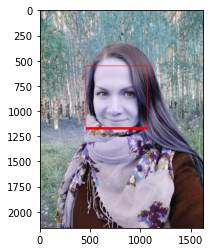

{'firstname': 'Светлана', 'lastname': 'Шишкина', 'country': 'Россия', 'birthdate': '5.3', 'sex': 'женский', 'city': 'Киров', 'job': [], 'education': [], 'contacts': [{'home_phone': 'не указано'}, {'mob_phone': 'не указано'}], 'military': 'не указано', 'photo': ['https://sun9-32.userapi.com/impg/aXlsNtJEeMbF9l2ZIMDw1CQGPjTt98jHcNzEFQ/defpW_XglVk.jpg?size=200x0&quality=90&crop=1,239,1079,1079&sign=f7fc86edaa43f73ffb67b1756137a51d&c_uniq_tag=YRGHxnErMYEgvLRZVE42F8IAYBdW29IcHGoATn6F3es&ava=1'], 'relation': {'relation': 'не указано'}, 'interests': {'Городское сообщество': 20.0, 'Спортивный комплекс': 5.0, 'Соседи': 5.0, 'Публичная страница': 5.0, 'Творчество': 10.0, 'Общественная организация': 5.0, 'Образование': 5.0, 'Химчистка, прачечная': 5.0, 'Активный отдых': 5.0, 'Развлечения': 5.0, 'Наука': 15.0, 'Юмор': 5.0, 'Другие хобби': 5.0, 'Интернет-СМИ': 5.0}}


127.0.0.1 - - [29/Nov/2020 10:42:50] "POST / HTTP/1.1" 200 -


[]


In [18]:
from flask import Flask, render_template, request, redirect, url_for, send_from_directory
from flask_ngrok import run_with_ngrok
import os
import time
app = Flask(__name__, template_folder = "/content/drive/MyDrive/Server/templates", static_folder = "/content/drive/MyDrive/Server/static")
run_with_ngrok(app)
ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1] in ALLOWED_EXTENSIONS

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        links = list()

        for i in range(10):
          links.append(request.form[str("url" + str(i))])

        for i in range(10):
          if links[i] != "":
            get_photos(links[i])

        
        for file in os.listdir('drive/MyDrive/Server/static/dataset/train2'):
            print(str(file))
            add_data("drive/MyDrive/Server/static/dataset/train2" + "/" + str(file))
            print("added")

        file = request.files['file']
        if file and allowed_file(file.filename):
            filename = file.filename
            path = os.path.join("/content/drive/MyDrive/Server/static/dataset/test", filename)
            file.save(path)

            answr = find_face(path)

            answr2 = get_data(answr)
            
            answr3 = interest_mapping(answr2[0]['interests'])  

            return render_template("index.html", url = str("https://vk.com/" + str(answr)), json1 = answr2[0], json2 = str(answr2[1]), json3 = str(answr2[2]), json4 = answr3)
            
    return render_template("index.html", json1 = [], json2 = "", json3 = "", json4 = [])


if __name__ == '__main__':
    load_data()
    app.run()